## Notebook for data exploration of the ZINC library
library imports

In [1]:
from pathlib import Path
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import urllib
import sys 

# local python
sys.path.append("..") # added!
from src.utils import *

### rdkit test
Python API: https://www.rdkit.org/docs/api-docs.html

just testing that rdkit is functioning, including visualization

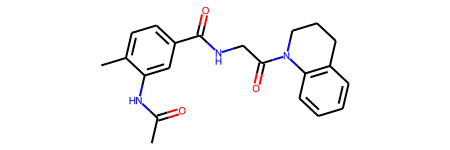

In [2]:
Chem.MolFromSmiles('Cc1ccc(cc1NC(=O)C)C(=O)NCC(=O)N2CCCc3c2cccc3')

### ZINC dataset
The current ZINC dataset is over 750 million compounds. As this is just an early data exploration, an older and more manageable set can be found here: https://zinc12.docking.org/browse/subsets/

I chose the largest dataset, which was All Purchasable compounds. Each subset has an excel file was available with properties (aka descriptor varaibles, molecular descriptors). The 'All Purchasable' file is here: https://zinc12.docking.org/db/bysubset/6/6_prop.xls

In [3]:
downloadRoot = "https://zinc12.docking.org/db/bysubset/" # URLs need to be strings. We can't use pathlib
dataPath = Path("..", "data", "ZINC")
propertiesPath = Path(dataPath, "Properties")
SMILESPath = Path(dataPath, "SMILES")
figuresPath = Path("..", "figures", "ZINC")
subsetID = str(6)
subsetURL = downloadRoot + "/" + subsetID + "/"
propertiesFile = subsetID + "_prop.xls"
referenceSMILESFile = subsetID + "_p0.smi.gz"

# Full URLs for properties spreadssheet and refererence SMILES
propertiesURL = subsetURL + propertiesFile
referenceSMILESURL = subsetURL +  referenceSMILESFile

os.makedirs(figuresPath, exist_ok=True)
os.makedirs(propertiesPath, exist_ok=True)
os.makedirs(SMILESPath, exist_ok=True)

I anticipated I'll need to pull multiple files from the remote URL, so created a reusable function in ```../src/utils.py``` for future use. The properties excel files are relatively large at 1.6 GB, and on my local machine took 20 minutes to download. The SMILES datafiles which are simply a list of ASCII strings are ~10% of the spreadsheet size, so took ~2 minutes.

In [6]:
fetchData(propertiesFile, subsetURL, propertiesPath) # fetches properties spreadsheet
fetchData(referenceSMILESFile, subsetURL, SMILESPath) # fetches SMILES strings

### Quick look at the data structure of the properties spreadsheet
- 9 numeric features
  - 4 continuous (float) features: ```MWT```, ```LogP```, ```Desolv_apolar```, ```Desolv_polar```
  - 5 discrete (int) features: ```HBD```, ```HBA```, ```Charge```, ```NRB```, ```tPSA```
- 2 categorical features

In [ ]:
propertiesFilePath = Path(dataPath, propertiesFile)

df = pd.read_csv(propertiesFilePath, sep='\t')
df.head()

In [ ]:
df.info()

In [ ]:
continuous_features = ['MWT', 'Desolv_polar', 'Desolv_apolar', 'LogP']
numeric_features = ['tPSA',  'HBD', 'HBA', 'Charge', 'NRB']
categorical_features = ['ZINC_ID', 'SMILES']

print('continuous features')
for feature in continuous_features:
    print('{} has {} unique elements'.format(feature, df[feature].nunique()))

print('\nnumeric features')
for feature in numeric_features:
    print('{} has {} unique elements'.format(feature, df[feature].nunique()))

In [ ]:
df.describe().apply(lambda s: s.apply('{0:.4f}'.format))

### Looking for Correlations
1. Pairplot
2. Correlation matrices (heatmaps)

The dataset is 16 million records, to reduce computation time, change `df` in line 6 to `df[::X]` where `X` is the step size to slice. If we wanted to avoid sampling bias `sklearn.model_selection.StratifiedShuffleSplit` allows a way for us to do stratified sampling. Ref: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

In [ ]:
# Commonly used plot settings
plt.rcParams.update({'font.size': 6, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 
                     'grid.linestyle': '-', 'grid.linewidth': .33, 
                     'legend.framealpha': 1, 'legend.facecolor': 'white', 'legend.shadow': False})

g = sns.pairplot(df, diag_kind='kde', height=1.2, plot_kws={"s": 0.5})

Correlation Matrices to go along with the pairplot
`Pearson` is preferred. However, `Spearman` and `Kendall` correlation coefficients are based on rank, so are more robust to outliers and can handle some types of nonlinearities. Though these types of methods are generally used for smaller datasets and specific hypothesis tests. I just used Kendall and Spearman here due to the weird shape of `Charge` vs `Desolv_polar`. Pearson shows a coefficient of -0.35, where Kendall shows -0.81 due to the apparent non-linear relationship between the two descriptor variables (features). 

I would've guessed that molecular weight would've had a stronger relationship with the number of hydrogen bond donors (HBD), number of hydrgeon bond acceptors (HBA) and charge as the mass goes up. However, this was just a limited look, but for feature engineering could consider scaling properties by mass, area and/or volume of molecule. 

For calculating free-energy binding values often area works better than volume, where for large macromolecules (e.g. proteins) volume tends to work better [TO DO: Find the ref on area vs volume study]


In [ ]:
methods = ['pearson', 'kendall', 'spearman']

plt.rcParams.update({'font.size': 4, 'xtick.labelsize': 4, 'ytick.labelsize': 4})
sns.set_style("whitegrid")

for method in methods:
    # generate figure and axes
    fig = plt.figure(figsize=(3, 2), dpi=300)
    ax = fig.add_axes([0.12, 0.12, 0.78, 0.78])
    
    # Compute the correlation matrix and generate upper triangle mask
    corr = df[::50].corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Draw the heatmap with the mask and correct aspect ratio
    heatmap = sns.heatmap(corr, mask=mask, cmap='seismic', 
                          vmin=-1, vmax=1, center=0, 
                          annot=True, fmt='.2f', 
                          square=True, linewidths=.5, 
                          cbar_kws={"shrink": .5})
    heatmap.set_title('{} correlation matrix'.format(method), fontdict={'fontsize':6}, pad=16)
    plt.savefig(Path(figuresPath, '{}_corr.png'.format(method)), dpi=300, bbox_inches='tight')

A closer look at the relationships between `tPSA` and `HBA` & `Charge` and `Desolv_polar`

In [ ]:
sns.set(style='darkgrid')
plt.rcParams.update({'font.size': 4, 'xtick.labelsize': 4, 'ytick.labelsize': 4})

fig = plt.figure(figsize=(3, 2), dpi=300)
ax = fig.add_axes([0.12, 0.12, 0.78, 0.78])

ax = sns.scatterplot(data=df, x="tPSA", y="HBA", s=1)

In [ ]:
sns.set(style='darkgrid')
plt.rcParams.update({'font.size': 4, 'xtick.labelsize': 4, 'ytick.labelsize': 4})

fig = plt.figure(figsize=(3, 2), dpi=300)
ax = fig.add_axes([0.12, 0.12, 0.78, 0.78])

ax = sns.scatterplot(data=df, x="Desolv_polar", y="Charge", s=1)

Looking at the countplot of charge on logscale we see that negative charged values are over-represented for -4 and -5 vs 4, 5 and 6. So if we were doing anything with charge we would need to be careful. 

In [ ]:
sns.set(style='darkgrid')
plt.rcParams.update({'font.size': 4, 'xtick.labelsize': 4, 'ytick.labelsize': 4})

fig = plt.figure(figsize=(2, 1), dpi=300)
ax = fig.add_axes([0.12, 0.12, 0.78, 0.78])


ax = sns.countplot(x=df['Charge'], palette='seismic', edgecolor='black', linewidth=0.5)
plt.yscale('log')

### Feature Engineering and a Look at the Structures

Molecules in the ZINC15 dataset can be downloaded as: 
- flexibase
- mol2
- SDF
- SMILES (isomeric)

I prefer to use InChi, as that will allow me to use other libraries (e.g. NIST17/20, PubChem). I will use the SMILES format and convert to InChi. However, I understand that conversion of one molecular format or another results in a loss of information as none of them are comprehensive, and are designed for specific purposes. I will need to do a literature search for a way to perform QA for SMILES <-> InChi conversions, and will consider some QA strategies on my own. 

The molecules are treated as being in neutral acidic/basic conditions (pH = 7), but there are three additional representations for some molecules:
- 4.5 to 7.0 (low pH): docking to a postively charged binding site
- 5.75 to 8.25 (medium pH): the set for most dockers. 
- 7.0 to 9.5 (high pH): docking to metals

Reference warns that you can download individiaul representations or all, though warns not to download All and a single representation to avoid duplicates. It was recommended that cheminformaticians may just want the single representation. As I'm exploring this dataset with no real objective in mind beyond just familiarizing myself with the dataset, I'm just going to use the neutral/usual single representation. I create an action item though in the repo to revisit pKa predictions so I can pull in some of my code from my graduate school research when i did pKa.

In [ ]:
fetch_property_data(propertiesURL, dataPath)

In [ ]:
feature = 'tPSA'
feature_list = df[feature].tolist()
print(len(feature_list))

plt.rcParams.update({'font.size': 4,
                     'xtick.labelsize': 4,
                     'ytick.labelsize': 4,
                     'grid.linestyle': '-',
                     'grid.linewidth': .33,
                     'legend.framealpha': 1,
                     'legend.facecolor': 'white',
                     'legend.shadow': False})

fig = plt.figure(figsize=(5,2), dpi=300)
ax = fig.add_axes([0.12, 0.12, 0.78, 0.78])

binwidth = 5
# binwidth = binwidthDict[feature]
plt.title(('{}, [min: {:2f}, min: {:2f}, min: {:2f}] bindwith={}'.format(feature, df[feature].min(), df[feature].mean(), df[feature].max(), binwidth)))

ax = sns.histplot(x=feature_list, edgecolor='k', linewidth=0.25, binwidth=binwidth)

mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
edges = [rect.get_x() for rect in ax.patches] + [ax.patches[-1].get_x() + ax.patches[-1].get_width()]
ax.set_xticks(sorted(set(edges)))

ax.tick_params(axis='x', rotation=90, labelsize=4, color='black', grid_color='grey', grid_alpha=0.5)

plt.savefig('figures/Dist_feature_{}.png'.format(feature), dpi=300, bbox_inches='tight')

In [ ]:
features = ['MWT', 'LogP', 'Desolv_apolar', 'Desolv_polar', 'tPSA']

binwidthDict = {'MWT': 10,
                'LogP': 0.4,
                'Desolv_apolar': 1.5,
                'Desolv_polar': 10,
                'tPSA': 5}

for feature in features:
    plt.rcParams.update({'font.size': 4,
                         'xtick.labelsize': 4,
                         'ytick.labelsize': 4,
                         'grid.linestyle': '-',
                         'grid.linewidth': .33,
                         'legend.framealpha': 1,
                         'legend.facecolor': 'white',
                         'legend.shadow': False})
    
    fig = plt.figure(figsize=(5,2), dpi=300)
    ax = fig.add_axes([0.12, 0.12, 0.78, 0.78])
    
    binwidth = binwidthDict[feature]
    plt.title(('{}, [min: {:.2f}, min: {:.2f}, min: {:.2f}] bindwith={}'.format(feature, df[feature].min(), df[feature].mean(), df[feature].max(), binwidth)))
    
    ax = sns.histplot(data=df, x=feature, edgecolor='k', linewidth=0.25, binwidth=binwidth)
    
    mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
    edges = [rect.get_x() for rect in ax.patches] + [ax.patches[-1].get_x() + ax.patches[-1].get_width()]
    ax.set_xticks(sorted(set(edges)))
    
    ax.tick_params(axis='x', rotation=90, labelsize=4, color='black', grid_color='grey', grid_alpha=0.5)
    
    plt.savefig('figures/Dist_feature_{}.png'.format(feature), dpi=300, bbox_inches='tight')

In [ ]:
feature = 'HBD'
feature_list = sorted(df[feature].tolist())
print(len(feature_list))



plt.rcParams.update({'font.size': 4,
                     'xtick.labelsize': 4,
                     'ytick.labelsize': 4,
                     'grid.linestyle': '-',
                     'grid.linewidth': .33,
                     'legend.framealpha': 1,
                     'legend.facecolor': 'white',
                     'legend.shadow': False})

fig = plt.figure(figsize=(5,2), dpi=300)
ax = fig.add_axes([0.12, 0.12, 0.78, 0.78])

binwidth = 5
# binwidth = binwidthDict[feature]
plt.title(('{}, [min: {:2f}, min: {:2f}, min: {:2f}] bindwith={}'.format(feature, df[feature].min(), df[feature].mean(), df[feature].max(), binwidth)))

ax = sns.countplot(x=feature_list, edgecolor='k', linewidth=0.25)

mids = [rect.get_x() + rect.get_width() / 2 for rect in ax.patches]
edges = [rect.get_x() for rect in ax.patches] + [ax.patches[-1].get_x() + ax.patches[-1].get_width()]
ax.set_xticks(sorted(set(edges)))

ax.tick_params(axis='x', rotation=90, labelsize=4, color='black', grid_color='grey', grid_alpha=0.5)

plt.savefig('figures/Dist_feature_{}.png'.format(feature), dpi=300, bbox_inches='tight')

In [ ]:
plt.rcParams.update({'font.size': 10,
                     'xtick.labelsize': 10,
                     'ytick.labelsize': 10,
                     'grid.linestyle': '-',
                     'grid.linewidth': .33,
                     'legend.framealpha': 1,
                     'legend.facecolor': 'white',
                     'legend.shadow': False})

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='seismic', vmin=-1, vmax=1, center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})